# Imports

In [1]:
 # * Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
 # * Setting Seed

seed = 7
np.random.seed(seed)

In [3]:
 # * Importing Data 

case_id = 3
case_file = f'Case_{case_id}.csv'
data = pd.read_csv(case_file)

In [4]:
 # * Plotting Data

def summarize_df(dataframe):
    df_summary = dataframe['DoA'].value_counts().reset_index()
    df_summary.columns = ['Label', 'Data Points']

    order = ['Light', 'Moderate', 'Deep']
    df_summary = df_summary.set_index('Label')
    df_summary = df_summary.reindex(order)
    df_summary = df_summary.reset_index()

    df_summary.loc[3] = ['TOTAL', np.sum(df_summary['Data Points'])]
    df_summary['Percentage'] = round((df_summary['Data Points'] / df_summary.loc[3, 'Data Points'] * 100), 2)

    return df_summary

data_summary = summarize_df(data)
print('Summary of Data:')
display(data_summary)

print('DataFrame:')
display(data)

Summary of Data:


,Label,Data Points,Percentage
0,Light,199,9.22
1,Moderate,418,19.37
2,Deep,1541,71.41
3,TOTAL,2158,100.00


DataFrame:


,Time,DoA,DoA Value,BIS Value,LF,HF,LF_HF,LF_nu,HF_nu,TP
0,62.164062,Light,0,96.500000,441.434921,241.237068,1.829880,64.662814,35.337186,1129.238685
1,63.164062,Light,0,94.500000,452.854653,243.833307,1.857230,65.001073,34.998927,1167.332969
2,64.164062,Light,0,94.500000,473.537364,248.500942,1.905576,65.583413,34.416587,1269.376660
3,65.164062,Light,0,94.500000,481.948069,251.377103,1.917231,65.720923,34.279077,1331.978063
4,66.164062,Light,0,93.599998,488.138690,252.550944,1.932833,65.903270,34.096730,1395.918799
...,...,...,...,...,...,...,...,...,...,...
2153,3601.179688,Moderate,1,58.000000,23.459648,3.387824,6.924696,87.381219,12.618781,50.798640
2154,3602.179688,Moderate,1,59.200001,22.643505,3.521987,6.429185,86.539573,13.460427,49.182323
2155,3603.179688,Light,0,61.500000,21.764018,3.622433,6.008121,85.730840,14.269160,47.503294
2156,3604.179688,Light,0,61.099998,20.893296,3.759595,5.557326,84.749881,15.250119,46.164067


# Data Preparation

In [5]:
 # * Selecting Data for Training and Testing

def balance_and_split(): # Function for balancing and train/test splitting the data points
    light_data = data[data['DoA Value'] == 0]
    moderate_data = data[data['DoA Value'] == 1]
    deep_data = data[data['DoA Value'] == 2]

    # Determines the class with the fewest data points
    length_classes = [len(light_data), len(moderate_data), len(deep_data)]
    shortest_len = min(length_classes)
    shortest_class = length_classes.index(shortest_len)

    # Resamples the other two classes to contain equal data points as the shortest class
    resampled_data = []
    for index, dataframe in enumerate([light_data, moderate_data, deep_data]):
        if index == shortest_class:
            resampled_data.append(dataframe)
        else:
            resampled_data.append(dataframe.sample(n = shortest_len, replace = False, random_state = seed))

    # Concatenate the resampled data
    resampled_data_concat = pd.concat(resampled_data)

    # Train/test splitting the combined resampled data
    train_data, test_data = train_test_split(resampled_data_concat, train_size = 0.8, random_state = seed)

    data_summary = summarize_df(train_data)
    print('Training Data:')
    display(data_summary)
    display(train_data)

    data_summary = summarize_df(test_data)
    print('Testing Data:')
    display(data_summary)
    display(test_data)

    return train_data, test_data

train_data, test_data = balance_and_split()

Training Data:


,Label,Data Points,Percentage
0,Light,166,34.80
1,Moderate,152,31.87
2,Deep,159,33.33
3,TOTAL,477,100.00


,Time,DoA,DoA Value,BIS Value,LF,HF,LF_HF,LF_nu,HF_nu,TP
25,202.162109,Light,0,97.199997,334.644934,222.495873,1.504050,60.064696,39.935304,870.465297
1962,3410.179688,Moderate,1,40.400002,39.834875,11.397248,3.495131,77.753708,22.246292,133.154440
319,997.162109,Deep,2,39.599998,16.537585,10.510639,1.573414,61.141112,38.858888,48.010416
456,1134.158203,Deep,2,34.799999,16.952401,10.649613,1.591832,61.417259,38.582741,385.499935
210,656.162109,Moderate,1,46.000000,13.423054,28.912416,0.464266,31.706402,68.293598,106.609263
...,...,...,...,...,...,...,...,...,...,...
1393,2721.179688,Deep,2,35.099998,11.624484,1.802424,6.449362,86.576032,13.423968,26.856473
805,2130.179688,Deep,2,31.100000,208.724673,208.660465,1.000308,50.007692,49.992308,457.933942
1354,2682.179688,Deep,2,35.599998,13.273784,1.381844,9.605851,90.571242,9.428758,19.905292
2155,3603.179688,Light,0,61.500000,21.764018,3.622433,6.008121,85.730840,14.269160,47.503294


Testing Data:


,Label,Data Points,Percentage
0,Light,33,27.50
1,Moderate,47,39.17
2,Deep,40,33.33
3,TOTAL,120,100.00


,Time,DoA,DoA Value,BIS Value,LF,HF,LF_HF,LF_nu,HF_nu,TP
2009,3457.179688,Moderate,1,45.000000,17.733912,4.345526,4.080959,80.318675,19.681325,96.879701
109,354.162109,Light,0,80.900002,20.528904,15.463309,1.327588,57.037072,42.962928,116.114404
285,731.162109,Deep,2,38.700001,14.417378,19.854294,0.726159,42.067916,57.932084,64.731973
1684,3012.179688,Deep,2,38.700001,7.419796,1.690932,4.387992,81.440209,18.559791,20.771945
2112,3560.179688,Moderate,1,56.799999,24.579417,2.713057,9.059676,90.059322,9.940678,62.559446
...,...,...,...,...,...,...,...,...,...,...
355,1033.158203,Deep,2,35.299999,27.271197,11.642305,2.342422,70.081580,29.918420,69.177047
32,209.162109,Light,0,97.699997,325.183726,188.924477,1.721237,63.252001,36.747999,1044.601405
22,199.162109,Light,0,97.099998,391.546304,244.622658,1.600613,61.547533,38.452467,935.474420
1290,2618.179688,Deep,2,28.799999,31.196565,1.621612,19.237998,95.058800,4.941200,59.534620


In [6]:
 # * Selecting Features

features = [data.columns[0]] + list(data.columns[6:9])
print(f'Selected Features: {features}')

Selected Features: ['Time', 'LF_HF', 'LF_nu', 'HF_nu']


In [7]:
 # * Formatting Data

X_train_unscaled = train_data[features].values
y_train = train_data['DoA Value'].values

X_test_unscaled = test_data[features].values
y_test = test_data['DoA Value'].values

In [8]:
 # * Scaling Features

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train_unscaled) # Applies standard scaler to featuers of train set
X_test = scaler.transform(X_test_unscaled) # Applies standard scaler to features of test set

# Decision Tree

In [9]:
 # * Constructing and Training DT Model

clf_DT = DecisionTreeClassifier(random_state = seed) # Constructs a DT with default parameters
clf_DT.fit(X_train, y_train) # Training the DT with the training set

# Calculates the CV Accuracy
cv_scores = cross_val_score(clf_DT, X_train, y_train, cv = 5)
mean_cv_score = cv_scores.mean() * 100
print(f'Cross Validation Accuracy: {mean_cv_score:.2f}%')

Cross Validation Accuracy: 94.76%


Test Accuracy: 91.67%
Class Accuracy:
Class 0: 93.94%
Class 1: 89.36%
Class 2: 92.50%


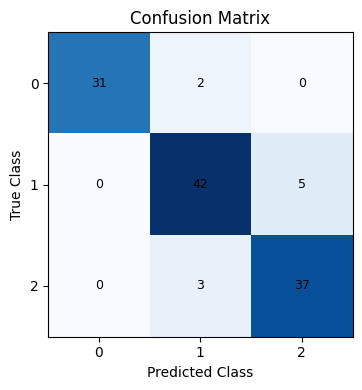

In [10]:
 # * Testing DT Model

y_pred = clf_DT.predict(X_test) # Applies the DT model on the test set

def accuracy(): # Computes the overall accuracy of the model
  accuracy = accuracy_score(y_test, y_pred) * 100
  print(f'Test Accuracy: {accuracy:.2f}%')
  
def accuracy_by_class(): # Computes the confusion matrix and per-class accuracies
  confusion_m = confusion_matrix(y_test, y_pred)

  print("Class Accuracy:")
  class_labels = ['Class 0', 'Class 1', 'Class 2']
  for i in range(len(class_labels)):
    accuracy = confusion_m[i, i] / sum(confusion_m[i, :]) * 100
    print(f"{class_labels[i]}: {accuracy:.2f}%")

  plt.figure(figsize=(6, 4))
  plt.imshow(confusion_m, cmap = plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.xticks(range(len(clf_DT.classes_)), clf_DT.classes_)
  plt.yticks(range(len(clf_DT.classes_)), clf_DT.classes_)
  for i in range(len(confusion_m)):
    for j in range(len(confusion_m)):
      plt.text(j, i, confusion_m[i, j], ha="center", va="center", fontsize=9)

  plt.tight_layout()
  plt.show()
  
accuracy()
accuracy_by_class()

In [11]:
 # * Optimizing DT Model

param_grid = { # Set up parameters for the model to try
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
    'splitter': ['best', 'random'],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state = seed), param_grid, cv = 5)
grid_search.fit(X_train, y_train) # Grid Search for the optimal parameters

optimal_params = grid_search.best_params_ # Stores the optimal parameters
optimal_score = grid_search.best_score_ * 100 # Stores the CV accuracy

print(f'Cross-Validation Accuracy: {optimal_score:.2f}%')
print('Optimal Parameters:')
display(pd.DataFrame(list(optimal_params.items()), columns = ['Key', 'Value']))


Cross-Validation Accuracy: 96.02%
Optimal Parameters:


,Key,Value
0,criterion,entropy
1,max_depth,9
2,min_samples_leaf,1
3,min_samples_split,2
4,splitter,best


Test Accuracy: 95.83%
Class Accuracy:
Class 0: 100.00%
Class 1: 93.62%
Class 2: 95.00%


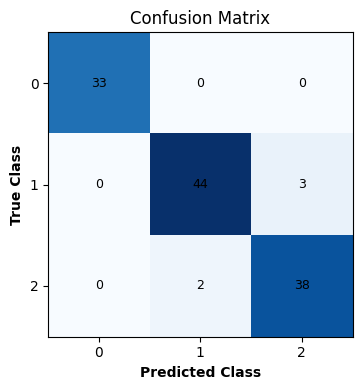

In [12]:
 # * Optimal DT Model

optimal_DT = DecisionTreeClassifier(random_state=seed, **optimal_params) # Construct a DT based on the optimal parameters found
optimal_DT.fit(X_train, y_train) # Training the DT with the training set

y_pred = optimal_DT.predict(X_test) # Applies the DT model on the test set

def accuracy(): # Computes the overall accuracy of the model
  accuracy = accuracy_score(y_test, y_pred) * 100
  print(f'Test Accuracy: {accuracy:.2f}%')

def accuracy_by_class(): # Computes the confusion matrix and per-class accuracies
  confusion_m = confusion_matrix(y_test, y_pred)

  print("Class Accuracy:")
  class_labels = ['Class 0', 'Class 1', 'Class 2']
  for i in range(len(class_labels)):
    accuracy = confusion_m[i, i] / sum(confusion_m[i, :]) * 100
    print(f"{class_labels[i]}: {accuracy:.2f}%")

  plt.figure(figsize=(6, 4))
  plt.imshow(confusion_m, cmap = plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Class", fontweight = 'bold')
  plt.ylabel("True Class", fontweight = 'bold')
  plt.xticks(range(len(optimal_DT.classes_)), optimal_DT.classes_)
  plt.yticks(range(len(optimal_DT.classes_)), optimal_DT.classes_)
  for i in range(len(confusion_m)):
    for j in range(len(confusion_m)):
      plt.text(j, i, confusion_m[i, j], ha = "center", va = "center", fontsize = 9)

  plt.tight_layout()
  plt.show()
  
accuracy()
accuracy_by_class()

# KNN

In [13]:
 # * Constructing and Training KNN Model

clf_knn = KNeighborsClassifier() # Consructs a KNN with default parameters
clf_knn.fit(X_train, y_train) # Training the KNN with the training set

# Calculates the CV Accuracy
cv_scores = cross_val_score(clf_knn, X_train, y_train, cv = 5)
mean_cv_score = cv_scores.mean() * 100
print(f'Cross Validation Accuracy: {mean_cv_score:.2f}%')

Cross Validation Accuracy: 92.46%


Test Accuracy: 89.17%
Class Accuracy:
Class 0: 93.94%
Class 1: 91.49%
Class 2: 82.50%


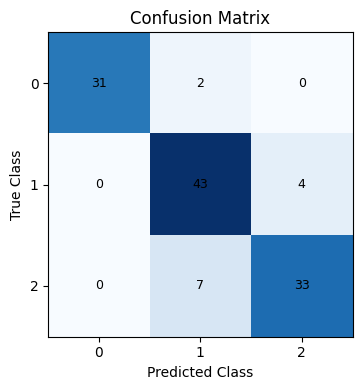

In [14]:
 # * Testing KNN Model

y_pred = clf_knn.predict(X_test) # Applies the KNN model on the test set

def accuracy(): # Computes the overall accuracy of the model
  accuracy = accuracy_score(y_test, y_pred) * 100
  print(f'Test Accuracy: {accuracy:.2f}%')

def accuracy_by_class(): # Computes the confusion matrix and per-class accuracies
  confusion_m = confusion_matrix(y_test, y_pred)

  print("Class Accuracy:")
  class_labels = ['Class 0', 'Class 1', 'Class 2']
  for i in range(len(class_labels)):
    accuracy = confusion_m[i, i] / sum(confusion_m[i, :]) * 100
    print(f"{class_labels[i]}: {accuracy:.2f}%")

  plt.figure(figsize=(6, 4))
  plt.imshow(confusion_m, cmap = plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.xticks(range(len(clf_knn.classes_)), clf_knn.classes_)
  plt.yticks(range(len(clf_knn.classes_)), clf_knn.classes_)
  for i in range(len(confusion_m)):
    for j in range(len(confusion_m)):
      plt.text(j, i, confusion_m[i, j], ha="center", va="center", fontsize=9)

  plt.tight_layout()
  plt.show()
  
accuracy()
accuracy_by_class()

In [15]:
 # * Optimizing KNN Model

param_grid = {'n_neighbors': range(1, 10), # Set up parameters for the model to try
              'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5)
grid_search.fit(X_train, y_train) # Grid Search for the optimal parameters

optimal_params = grid_search.best_params_ # Stores the optimal parameters
optimal_score = grid_search.best_score_ * 100 # Stores the CV accuracy

print(f'Cross-Validation Accuracy: {optimal_score:.2f}%')
print('Optimal Parameters:')
display(pd.DataFrame(list(optimal_params.items()), columns = ['Key', 'Value']))


Cross-Validation Accuracy: 93.50%
Optimal Parameters:


,Key,Value
0,n_neighbors,3
1,weights,uniform


Test Accuracy: 86.67%
Class Accuracy:
Class 0: 93.94%
Class 1: 87.23%
Class 2: 80.00%


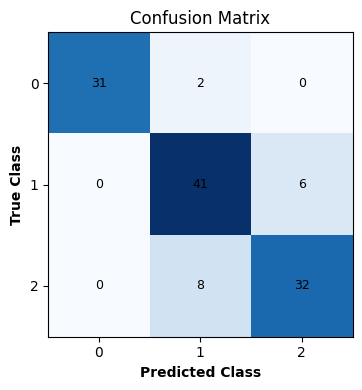

In [16]:
 # * Optimal KNN Model

optimal_knn = KNeighborsClassifier(**optimal_params)  # Construct a KNN based on the optimal parameters found
optimal_knn.fit(X_train, y_train) # Training the KNN with the training set

y_pred = optimal_knn.predict(X_test) # Applies the KNN model on the test set

def accuracy(): # Computes the overall accuracy of the model
  accuracy = accuracy_score(y_test, y_pred) * 100
  print(f'Test Accuracy: {accuracy:.2f}%')

def accuracy_by_class(): # Computes the confusion matrix and per-class accuracies
  confusion_m = confusion_matrix(y_test, y_pred)

  print("Class Accuracy:")
  class_labels = ['Class 0', 'Class 1', 'Class 2']
  for i in range(len(class_labels)):
    accuracy = confusion_m[i, i] / sum(confusion_m[i, :]) * 100
    print(f"{class_labels[i]}: {accuracy:.2f}%")

  plt.figure(figsize=(6, 4))
  plt.imshow(confusion_m, cmap = plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Class", fontweight = 'bold')
  plt.ylabel("True Class", fontweight = 'bold')
  plt.xticks(range(len(optimal_knn.classes_)), optimal_knn.classes_)
  plt.yticks(range(len(optimal_knn.classes_)), optimal_knn.classes_)
  for i in range(len(confusion_m)):
    for j in range(len(confusion_m)):
      plt.text(j, i, confusion_m[i, j], ha = "center", va = "center", fontsize = 9)

  plt.tight_layout()
  plt.show()
  
accuracy()
accuracy_by_class()